`RandomList` is a class that helps to select an entry from a weighted random list. It is used to select Gaussian clusters from Gaussian mixture.

In [6]:
from typing import TypeVar, Generic, List, Final

T = TypeVar('T')


class WeightedEntry(Generic[T]):

    def __init__(self, weight: float, data: T):
        self.weight: Final = weight
        self.data: Final = data


class RandomList(Generic[T]):

    def __init__(self):
        self.list: List[WeightedEntry[T]] = []
        self.sum_weight = 0

    def add_entry(self, weight: float, obj: T):
        if weight <= 0:
            raise AssertionError("invalid weight: " + str(weight))
        self.list.append(WeightedEntry(weight, obj))
        self.sum_weight += weight

    def get_random_entry(self, rand_number: float):
        if rand_number < 0 or rand_number > 1 or len(self.list) == 0 or self.sum_weight <= 0:
            raise AssertionError("invalid list")
        rand_number *= self.sum_weight
        for entry in self.list:
            rand_number -= entry.weight
            if rand_number < 0:
                return entry.data
        raise AssertionError("failed to find entry")


`GaussianVariable` represents one Gaussian cluster. It receievs mean and A matrix, where A times transpose of A equals to the covariance.
- `sample_data`: function to give a random vector that follows the distribution represented by this cluster
- `get_density`: get the value of density function at one location

`GaussianMixture` represents one Gaussian mixture. It is a weighted random list of Gaussian clusters.
- `get_random_data` gives an array of sample data generated according to the distribution of this mixture
- `get_density` provides the value of density function represented by this mixture

In [20]:
import numpy as np
import math


class GaussianVariable(object):

    def __init__(self, n: int, mean: np.ndarray, a: np.ndarray):
        self.n = n
        self.mean = mean
        self.a = a
        if mean.shape != (n,):
            raise AssertionError("mean dimension mismatch")
        if a.shape != (n, n):
            raise AssertionError("cov dimension mismatch")

    def sample_data(self):
        iid = np.random.standard_normal((self.n,))
        return self.mean + np.matmul(self.a, iid)

    def get_density(self, data: np.ndarray):
        c = np.matmul(self.a, np.transpose(self.a))
        x = data - self.mean
        coef = math.pow(2 * math.pi * np.linalg.det(c), -1 / 2)
        expm = -np.matmul(np.matmul(x, np.linalg.inv(c)), np.transpose(x)) / 2
        return coef * math.exp(expm)


class GaussianMixture(RandomList[GaussianVariable]):

    def __init__(self, n: int):
        super().__init__()
        self.n = n

    def add_gaussian(self, weight: float, mean: np.ndarray, a: np.ndarray):
        self.add_entry(weight, GaussianVariable(self.n, mean, a))

    def get_random_data(self, size: int, seed: int = 0):
        np.random.seed(seed)
        choice = np.random.random((size,))
        return np.asarray([self.get_random_entry(val).sample_data() for val in choice], np.single)

    def get_density(self, data: np.ndarray):
        chance = 0
        for entry in self.list:
            chance += entry.weight * entry.data.get_density(data)
        return chance


### Problem 0
`a_from_eigen_angle` generates the A matrix from eigen values and angle of eigen vectors
Then I construct the mixtures, collect samples, and plot them. Blue dots are the class 0 points, and orange dots are the class 1 points.

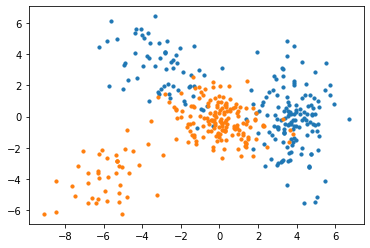

In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt

def a_from_eigen_angle(eig_1, eig_2, theta):
    eig_vector = np.transpose(np.array([[math.cos(theta), math.sin(theta)], 
            [-math.sin(theta), math.cos(theta)]]))
    eig_value = np.diag([math.sqrt(eig_1), math.sqrt(eig_2)])
    return np.matmul(eig_vector, eig_value)

mixture_0 = GaussianMixture(2)
mixture_0.add_gaussian(2 / 3, np.array([4, 0]), 
        a_from_eigen_angle(1, 4, 0))
mixture_0.add_gaussian(1 / 3, np.array([-3, 3]), 
        a_from_eigen_angle(1, 4, math.pi / 4))
sample_0 = mixture_0.get_random_data(200, 0)
plt.scatter(sample_0[:, 0], sample_0[:, 1],s=10)


mixture_1 = GaussianMixture(2)
mixture_1.add_gaussian(3 / 4, np.array([0, 0]), 
        a_from_eigen_angle(1, 2, math.pi / 3))
mixture_1.add_gaussian(1 / 4, np.array([-6, -4]), 
        a_from_eigen_angle(2, 1, math.pi / 4))
sample_1 = mixture_1.get_random_data(200, 0)
plt.scatter(sample_1[:, 0], sample_1[:, 1],s=10)


Here I create a 500x500 mesh grid, and fill with the difference of PDF of two mixtures. Positive value means it represents areas that will be classified as class 1 by MAP. Negative value means it represents areas that will be classified as class 0 by MAP.

In [9]:
gran = 500
X, Y = np.meshgrid(np.linspace(-10, 10, gran), np.linspace(-10, 10, gran))
Z = np.zeros((gran,gran))
for i in range(gran):
    for j in range(gran):
        Z[i,j] = mixture_1.get_density(np.array([X[i,j],Y[i,j]]))-mixture_0.get_density(np.array([X[i,j],Y[i,j]]))



Then I classify the sample data based on MAP. 

Blue region is the region classified as class 0 by MAP. 

Orange region is the region classified as class 1 by MAP. 

White dots are the sample data points that are classified correctly. 

Blue x's are the sample data points that are from class 0 but classified as class 1.

Orange x's are the sample data points that are from class 1 but classified as class 0.

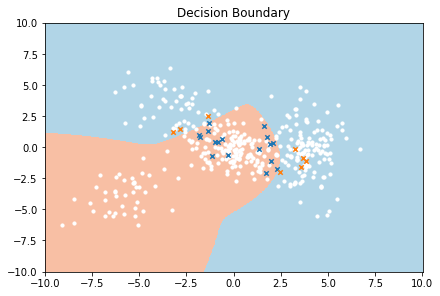

In [10]:
W = np.sign(Z)*0.3
fig, axs = plt.subplots(1, 1, layout='constrained')
pc = axs.pcolormesh(X, Y, W, vmin=-1, vmax=1, cmap='RdBu_r')
axs.set_title('Decision Boundary')

c0a = [mixture_0.get_density(sample_0[i])>mixture_1.get_density(sample_0[i]) for i in range(200)]
c0b = [not c0a[i] for i in range(200)]

c1a = [mixture_1.get_density(sample_1[i])>mixture_0.get_density(sample_1[i]) for i in range(200)]
c1b = [not c1a[i] for i in range(200)]
plt.scatter(sample_0[c0a, 0], sample_0[c0a, 1], s = 10, c='#ffffff',marker='o')
plt.scatter(sample_1[c1a, 0], sample_1[c1a, 1], s = 10,c='#ffffff',marker='o')
plt.scatter(sample_0[c0b, 0], sample_0[c0b, 1], s = 20, c='#1f77b4',marker='x')
plt.scatter(sample_1[c1b, 0], sample_1[c1b, 1], s = 20,c='#ff7f0e',marker='x')

### Problem 3
Here I collect 100k sample data to calculate the rate of misclassification.

In [22]:
n = 100000
err_0 = 0
err_1 = 0
map_sample_0 = mixture_0.get_random_data(n, 0)
map_sample_1 = mixture_1.get_random_data(n, 0)
for i in range(n):
    if mixture_1.get_density(map_sample_0[i]) > mixture_0.get_density(map_sample_0[i]):
        err_0 += 1
    if mixture_0.get_density(map_sample_1[i]) > mixture_1.get_density(map_sample_1[i]):
        err_1 += 1
print(err_0, err_1)

8414 5879


In [288]:

test_sample_0 = mixture_0.get_random_data(n, 0)
test_sample_1 = mixture_1.get_random_data(n, 0)

Verify that `n` is large enough

In [23]:
print(10*n/err_0)
print(10*n/err_1)

118.84953648680771
170.09695526450076


Thus, we can know that the error probabilities are 8.41% and 5.88% respectively.

In [193]:
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace       # hybrid frontend decorator and tracing jit

class Net(nn.Module):

    def __init__(self, n_in, n_hidden):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = F.relu(x)
        x = self.fc2.forward(x)
        return x



In [289]:
def gen_sample(data_0, data_1, n):
    return torch.from_numpy(np.concatenate((data_0[0:n, :], data_1[0:n, :])))

def train_H1(n_sample, l2_lambda, lrate, neurons, momentum, eps):
    net = Net(2, neurons)
    optimizer = optim.SGD(net.parameters(), lr=lrate, momentum=momentum)
    optimizer.zero_grad()
    criterion = nn.BCEWithLogitsLoss()
    data = gen_sample(map_sample_0, map_sample_1, n_sample)
    test = gen_sample(test_sample_0, test_sample_1, n_sample)
    label = torch.from_numpy(np.concatenate((np.zeros((n_sample,), np.single),np.ones((n_sample,), np.single)))).view([n_sample*2,1])

    list_lv = []
    list_lvr = []
    list_ac0 = []
    list_ac1 = []
    prev = 1e3
    lv = 1e2
    while abs(prev-lv) > lv*eps:
        prev = lv

        output = net.forward(data)
        loss = criterion(output, label)
        lv = loss.item()
        l2_norm = sum(p.pow(2).sum() for p in net.parameters())
        loss = loss + l2_lambda * l2_norm
        lvr = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        list_lv.append(lv)
        list_lvr.append(lvr)

        output = net.forward(test)
        ac_0 = int(torch.count_nonzero(output.data[0:n_sample] > 0))/n_sample
        ac_1 = int(torch.count_nonzero(output.data[n_sample:-1] < 0))/n_sample
        list_ac0.append(ac_0)
        list_ac1.append(ac_1)
    return {"net":net ,"lv":list_lv, "lvr":list_lvr, "ac0":list_ac0, "ac1":list_ac1}


In [290]:
n32m90e4 = train_H1(20000, 1e-3, 1e-3, 32, 0.9, 1e-4)
n32m00e4 = train_H1(20000, 1e-3, 1e-3, 32, 0, 1e-4)
n32m95e4 = train_H1(20000, 1e-3, 1e-3, 32, 0.95, 1e-4)
n32m80e4 = train_H1(20000, 1e-3, 1e-3, 32, 0.80, 1e-4)


In [291]:
n04m90e4 = train_H1(20000, 1e-3, 1e-3, 4, 0.9, 1e-4)
n08m90e4 = train_H1(20000, 1e-3, 1e-3, 8, 0.9, 1e-4)
n16m90e4 = train_H1(20000, 1e-3, 1e-3, 16, 0.9, 1e-4)
n24m90e4 = train_H1(20000, 1e-3, 1e-3, 24, 0.9, 1e-4)
n48m90e4 = train_H1(20000, 1e-3, 1e-3, 48, 0.9, 1e-4)

In [292]:

n32m90e5 = train_H1(20000, 1e-3, 1e-3, 32, 0.9, 1e-5)

0.07289999999999999

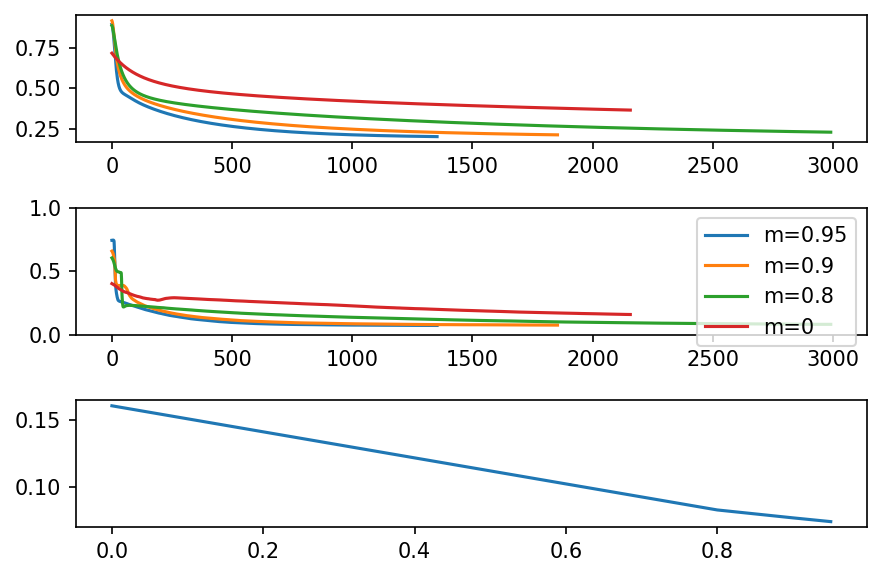

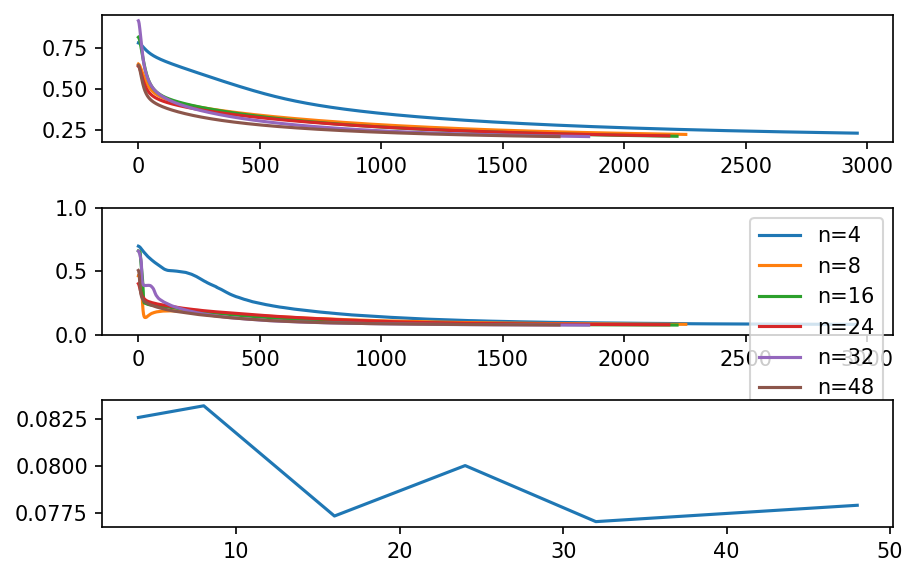

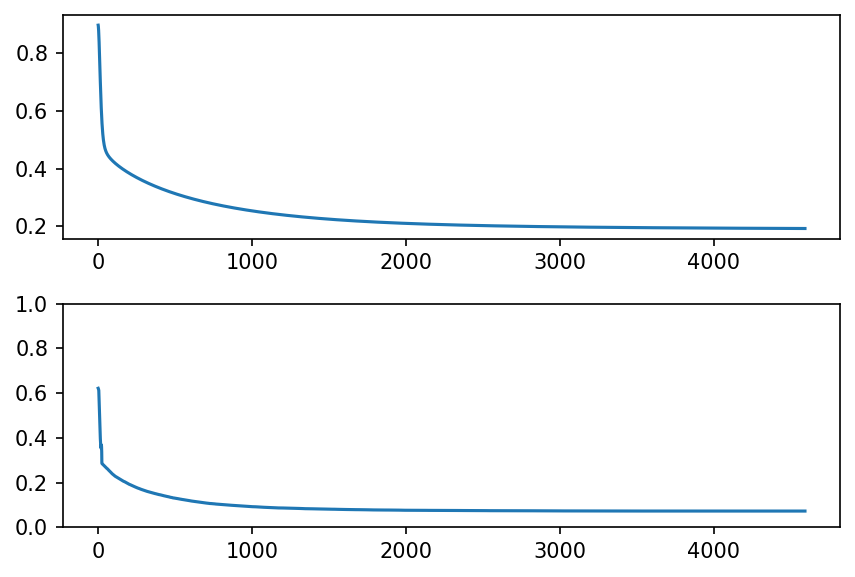

In [293]:


def plotasc(axs, model):

    list_lv = model["lv"]
    list_lvr = model["lvr"]
    list_ac0 = model["ac0"]
    list_ac1 = model["ac1"]
    list_ac = (np.array(list_ac0)+np.array(list_ac1))/2

    axs[0].plot(list_lv)
    #axs[0].plot(list_lvr)

    #axs[1].plot(list_ac0)
    #axs[1].plot(list_ac1)
    axs[1].plot(list_ac)
    axs[1].set_ylim(0,1)

    return min(list_ac)


fig, axs = plt.subplots(3, 1, dpi=150)
plt.tight_layout()
vals = [plotasc(axs, n32m95e4),
plotasc(axs, n32m90e4),
plotasc(axs, n32m80e4),
plotasc(axs, n32m00e4)]
axs[1].legend(['m=0.95','m=0.9','m=0.8','m=0'])
axs[2].plot([0.95,0.9,0.8,0],vals)
fig, axs = plt.subplots(3, 1, dpi=150)
plt.tight_layout()
vals = [plotasc(axs, n04m90e4),
plotasc(axs, n08m90e4),
plotasc(axs, n16m90e4),
plotasc(axs, n24m90e4),
plotasc(axs, n32m90e4),
plotasc(axs, n48m90e4)]
axs[1].legend(['n=4','n=8','n=16','n=24','n=32','n=48'])
axs[2].plot([4,8,16,24,32,48],vals)
fig, axs = plt.subplots(2, 1, dpi=150)
plt.tight_layout()
plotasc(axs, n32m90e5)